# 1. Giới thiệu bài toán:
   Quora là nền tảng hỏi đáp được tạo ra với mục đích học hỏi và chia sẻ kiến thức. Tuy nhiên, bên cạnh những câu hỏi mang tính tìm tòi, học hỏi đơn thuần thì còn có những câu hỏi được đặt ra với mục đích gây tranh cãi, mang tính tiêu cực. Vì vậy, xây dựng mô hình phân loại những câu hỏi chân thành(sincere question) và những câu hỏi không chân thành(insincere question) là nhiệm vụ cần thiết.
   <br>
   **Input:** Câu hỏi(dữ liệu text)
   <br>
   **Output:** Label Sincere (0), Insincere (1)


# 2. Data

In [ ]:
import os
import json
import string
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

Dữ liệu gồm những file sau:

In [ ]:
!ls ../input/

* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - A sample submission in correct format
* embeddings/ - Folder containing word embeddings 

In [ ]:
!ls ../input/quora-insincere-questions-classification/

* GoogleNews-vectors-negative300 - https://code.google.com/archive/p/word2vec/
* glove.840B.300d - https://nlp.stanford.edu/projects/glove/
* paragram_300_sl999 - https://cogcomp.org/page/resource_view/106
* wiki-news-300d-1M - https://fasttext.cc/docs/en/english-vectors.html

In [ ]:
train_df = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_df = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

In [ ]:
train_df.head()

Nhìn vào phân bố targer ta thấy các giá trị không cân bằng, số lượng nhãn '0' lớn hơn nhiều lần nhãn '1'.

In [ ]:
## target count ##
cnt_srs = train_df['target'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

Khoảng 6% training set là insincere questions (target=1) và phần còn lại là sincere.



**Word Cloud:**
Tần số xuất hiện của từ trong tập dữ liệu, tính bằng cách tạo một 'word cloud' trên cột 'question_text'

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df["question_text"], title="Word Cloud of Questions")

**Word Frequency plot of sincere & insincere questions:**

In [ ]:
from collections import defaultdict
train1_df = train_df[train_df["target"]==1]
train0_df = train_df[train_df["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

#plt.figure(figsize=(10,16))
#sns.barplot(x="ngram_count", y="ngram", data=fd_sorted.loc[:50,:], color="b")
#plt.title("Frequent words for Insincere Questions", fontsize=16)
#plt.show()

Quan sát ta thấy:
* Một vài từ có tần suất cao xuất hiện chung ở cả hai lớp như 'people', 'will', 'think',...
* Những top words khác trong class sincere là 'best', 'good',...
* Những top words khác trong class insincere là 'trump', 'women', 'white',...


**Phân bố bigram:**

In [ ]:
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions", 
                                          "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

# 3. Data preprocessing

In [ ]:
train = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")

**Xử lý data :**
<br>
Bỏ các từ không mang nghĩa và dấu (stopword, punctual), đổi chữ hoa thành chữ thường, lemmatize (đưa chữ về một dạng thống nhất).

In [ ]:
from gensim.utils import simple_preprocess 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english')) 
wordnet_lemmatizer = WordNetLemmatizer()
def preprocessing(corpus):
    res = []
    for doc in corpus:
        words = []
        for word in simple_preprocess(doc):
            if word not in stop_words:
                word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
                word2 = wordnet_lemmatizer.lemmatize(word1,pos = "v")
                word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
                words.append(word3)
                pass
            pass
        res.append(' '.join(words))        
        pass
    return res

Ví dụ:

In [ ]:
preprocessing(['Is a PhD really worth pursuing? How many PhD students can really get ‘productive’ or real time use output from their PhD research?'])

Áp dụng lên tập train và test:

In [ ]:
%%time
train['question_text'] = preprocessing(train['question_text'])
test['question_text'] = preprocessing(test['question_text'])

# 4. Trích xuất đặc trưng

Chọn TF-IDF làm đặc trưng, công thức là:
<br>
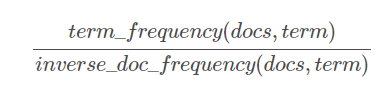
<br>
trong đó term frequency đại diện cho số lần một term xuất hiện trong docs và inverse doc frequency đại diện cho số doc xuất hiện term đấy. Một term đặc trưng của một văn bản thì sẽ là term xuất hiện nhiều nhất trong văn bản đấy. Nhưng khi so sánh giữa nhiều văn bản với nhau, những từ xuất hiện ở càng ít văn bản thì lại càng trở nên đặc trưng và có ý nghĩa phân loại hơn những từ xuất hiện ở đa số văn bản, vì thế nên công thức chia cho IDF để giảm tần số của những từ đại trà đấy. Dùng scikit để trích xuất những term gồm một hoặc 2 từ liền nhau (bi-gram)

In [ ]:
vector = TfidfVectorizer( ngram_range = (1,2))
train_feature_matrics = vector.fit_transform(train['question_text'].values.astype('U'))
test_feature_matrics = vector.transform(test['question_text'].values.astype('U'))

In [ ]:
train_feature_matrics

# 5. Model

Chọn F1 là metric chính để đánh giá model. Vì data bị lệch nên accuracy có vẻ không tốt bằng F1

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

Học tf-idf đã extract ở trên bằng mô hình logistic regression. Thử tunning tham số regularize C.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
train_x, valid_x, train_y, valid_y = train_test_split(train_feature_matrics, train['target'], test_size=0.25, shuffle=False)
C = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]

In [ ]:
for c in C:
    model = LogisticRegression(solver='liblinear', penalty='l2', C=c)
    model.fit(train_x, train_y)
    prediction = model.predict(valid_x)
    f1 = f1_score(valid_y, prediction)
    acc = accuracy_score(valid_y, prediction)
    print("Regularization: ", c)
    print("F1 score: ",f1)
    print("Acc score: ",acc)

Có thể thấy giá trị C tốt nhất là 30. Vì hàm predict sẽ trả về một sample là sincere hay không bằng cách so sánh xác suất đầu ra với một giá trị mặc định threshold = 0.5 (decision bound = 0), thử thay đổi mức threshold này.

In [ ]:
thresholds = [0.5, 0.1, 0.14, 0.15, 0.16, 0.17, 0.25, 0.3, 0.4, 0.55, 0.7]
c = 30
model = LogisticRegression(solver='liblinear', penalty='l2', C=c)
model.fit(train_x, train_y)
predict = model.predict_proba(valid_x)[:,1]
for t in thresholds:
    predict_t = np.where(predict > t, 1, 0)
    f1 = f1_score(valid_y, predict_t)
    print("Threshold: ", t)
    print("F1 score: ", f1)

Có vẻ chọn t = 0.16 là tốt nhất cho tập validate.

In [ ]:
t = 0.16
predict = model.predict_proba(valid_x)[:,1]
predict = np.where(predict > t, 1, 0)

In [ ]:
confusion_matrix(valid_y, predict)

Vì số sample có nhãn 1 chỉ chiếm 6% tổng số sample, thử sử dụng class weight để cải tiến model. Coi 1 sample có label 1 như 14 samples có label 0.

In [ ]:
class_weight = {0: 1., 1: 14.}
thresholds = [0.1, 0.25, 0.3, 0.35, 0.4, 0.55, 0.6, 0.7, 0.8, 0.85, 0.9]
c = 30
model = LogisticRegression(solver='liblinear', penalty='l2', C=c, class_weight = class_weight)
model.fit(train_x, train_y)
predict = model.predict_proba(valid_x)[:,1]
for t in thresholds:
    predict_t = np.where(predict > t, 1, 0)
    f1 = f1_score(valid_y, predict_t)
    print("Threshold: ", t)
    print("F1 score: ", f1)

Có vẻ F1 của model này kém hơn model không có class weight, chọn model trước làm model cuối cùng để test.

In [ ]:
model = LogisticRegression(solver='liblinear', penalty='l2', C=30)
model.fit(train_feature_matrics, train['target'])
predict = model.predict_proba(test_feature_matrics)[:,1]
predict = np.where(predict > 0.17, 1, 0)

In [ ]:
test['prediction'] = predict
results = test[['qid', 'prediction']]
results.to_csv('submission.csv', index=False)
results.shape